In [1]:
import collections
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, LSTM, Input, Dense, TimeDistributed, Embedding, Activation, RepeatVector, Bidirectional, Concatenate, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.preprocessing.text import one_hot
from keras.utils import np_utils

from sklearn.preprocessing import label_binarize

Using TensorFlow backend.


In [0]:
import pandas as pd

In [0]:
train = pd.read_csv('/content/DataSet/train.csv')
test = pd.read_csv('/content/DataSet/test.csv')
val = pd.read_csv('/content/DataSet/validation.csv')


In [0]:
#train.head(5)

In [5]:
x_train = train['sentence'].as_matrix()
y_train = train['relation'].as_matrix()

x_test = test['sentence'].as_matrix()
y_test = test['relation'].as_matrix()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [6]:
x_test.shape

(4566,)

In [0]:
x_train2=[]
y_train2=[]

for i in range(13340):
  if y_train[i] == 'causes':
    x_train2.append(x_train[i])
    y_train2.append(y_train[i])
  elif y_train[i] == 'treats':
    x_train2.append(x_train[i])
    y_train2.append(y_train[i])  
    
x_test2=[]
y_test2=[]

for i in range(4566):
  if y_test[i] == 'causes':
    x_test2.append(x_test[i])
    y_test2.append(y_test[i])
  elif y_test[i] == 'treats':
    x_test2.append(x_test[i])
    y_test2.append(y_test[i]) 

In [8]:
x_train2 = np.asarray(x_train2)
y_train2 = np.asarray(y_train2)
x_train2.shape

(12146,)

In [9]:
x_test2 = np.asarray(x_test2)
y_test2 = np.asarray(y_test2)
x_test2.shape

(4018,)

In [10]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
aW=[]
# Removing Stop Words
import re 
processed_article = x_train2

for j in range(x_train2.shape[0]):  
    processed_article[j] = re.sub("'S", ' ', processed_article[j])  
    processed_article[j] = re.sub('[^a-zA-Z]', ' ', processed_article[j])    
    processed_article[j] = re.sub(r'\s+', ' ', processed_article[j])
    # Preparing the dataset
    all_sentences = nltk.sent_tokenize(processed_article[j])
    all_words = [nltk.word_tokenize(sent) for sent in all_sentences]
    for i in range(len(all_words)):
      
        all_words[i] = [w.lower() for w in all_words[i] if w not in stopwords.words('english')]
        all_words[i] = [w for w in all_words[i] if w not in ['s','l','a','the','of','v','tu']]

    aW.append(all_words[0])

In [0]:
aWt=[]
# Removing Stop Words
import re 
processed_article = x_test2

for j in range(x_test2.shape[0]):  
    processed_article[j] = re.sub("'S", ' ', processed_article[j])  
    processed_article[j] = re.sub('[^a-zA-Z]', ' ', processed_article[j])    
    processed_article[j] = re.sub(r'\s+', ' ', processed_article[j])
    # Preparing the dataset
    all_sentences = nltk.sent_tokenize(processed_article[j])
    all_words = [nltk.word_tokenize(sent) for sent in all_sentences]
    for i in range(len(all_words)):
      
        all_words[i] = [w.lower() for w in all_words[i] if w not in stopwords.words('english')]
        all_words[i] = [w for w in all_words[i] if w not in ['s','l','a','the','of','v','tu']]

    aWt.append(all_words[0])

In [0]:
max_fatures = 7000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(aW)
X = tokenizer.texts_to_sequences(aW)

In [0]:
max_fatures = 7000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(aWt)
Xt = tokenizer.texts_to_sequences(aWt)

In [15]:
from keras.preprocessing.sequence import pad_sequences
Xpad=pad_sequences(X,padding='post')
voc=Xpad[0].size
print('El tamaño maximo de la secuencia es '+ str(Xpad[0].size))

El tamaño maximo de la secuencia es 74


In [16]:
Xpadt=pad_sequences(Xt,padding='post')
voct=Xpadt[0].size
print('El tamaño maximo de la secuencia es '+ str(Xpadt[0].size))

El tamaño maximo de la secuencia es 66


In [0]:
max=0
pos = []
newX = []
for i in range (len(X)):
  ant=len(X[i]) 
  if ant < 25:
    pos.append(i)
    newX.append(X[i])

In [18]:
len(pos)

10129

In [0]:
max=0
post = []
newXt = []
for i in range (len(Xt)):
  ant=len(Xt[i]) 
  if ant < 25:
    post.append(i)
    newXt.append(Xt[i])

In [20]:
len(post)

3410

In [0]:
newXTrain = []
newYTrain = []
#x_train2 = pd.DataFrame(x_train2)
#y_train2 = pd.DataFrame(y_train2)

for j in range (10129):
  
  newXTrain.append(x_train2[pos[j]])
  newYTrain.append(y_train2[pos[j]])

In [0]:
newXTest = []
newYTest = []
#x_train2 = pd.DataFrame(x_train2)
#y_train2 = pd.DataFrame(y_train2)

for j in range (3410):
  
  newXTest.append(x_test2[post[j]])
  newYTest.append(y_test2[post[j]])

In [23]:
newXTrain = np.asarray(newXTrain)
aW=[]
# Removing Stop Words
import re 
processed_article = newXTrain

for j in range(newXTrain.shape[0]):  
    processed_article[j] = re.sub("'S", ' ', processed_article[j])  
    processed_article[j] = re.sub('[^a-zA-Z]', ' ', processed_article[j])    
    processed_article[j] = re.sub(r'\s+', ' ', processed_article[j])
    # Preparing the dataset
    all_sentences = nltk.sent_tokenize(processed_article[j])
    all_words = [nltk.word_tokenize(sent) for sent in all_sentences]
    for i in range(len(all_words)):
      
        all_words[i] = [w.lower() for w in all_words[i] if w not in stopwords.words('english')]
        all_words[i] = [w for w in all_words[i] if w not in ['s','l','a','the','of','v','tu']]

    aW.append(all_words[0])
    
max_fatures = 7000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(aW)
X = tokenizer.texts_to_sequences(aW)


Xpad=pad_sequences(X,padding='post')
voc=Xpad[0].size
print('El tamaño maximo de la secuencia es '+ str(Xpad[0].size))

El tamaño maximo de la secuencia es 31


In [24]:
newXTest = np.asarray(newXTest)
aW=[]
# Removing Stop Words
import re 
processed_article = newXTest

for j in range(newXTest.shape[0]):  
    processed_article[j] = re.sub("'S", ' ', processed_article[j])  
    processed_article[j] = re.sub('[^a-zA-Z]', ' ', processed_article[j])    
    processed_article[j] = re.sub(r'\s+', ' ', processed_article[j])
    # Preparing the dataset
    all_sentences = nltk.sent_tokenize(processed_article[j])
    all_words = [nltk.word_tokenize(sent) for sent in all_sentences]
    for i in range(len(all_words)):
      
        all_words[i] = [w.lower() for w in all_words[i] if w not in stopwords.words('english')]
        all_words[i] = [w for w in all_words[i] if w not in ['s','l','a','the','of','v','tu']]

    aW.append(all_words[0])
    
max_fatures = 7000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(aW)
X2 = tokenizer.texts_to_sequences(aW)


Xpad2=pad_sequences(X2,padding='post')
voc2=Xpad2[0].size
print('El tamaño maximo de la secuencia es '+ str(Xpad2[0].size))

El tamaño maximo de la secuencia es 24


In [0]:
from keras.layers import Dense,LSTM,Dropout,GRU,SimpleRNN,Embedding
from keras.models import Sequential
from sklearn.model_selection import train_test_split

In [0]:
newYTest = np.asarray(newYTest)
newYTest = pd.DataFrame(newYTest)
y_test = label_binarize(newYTest, classes=newYTest[0].unique())

In [27]:
y_test.shape

(3410, 1)

In [0]:
newYTrain = np.asarray(newYTrain)
newYTrain = pd.DataFrame(newYTrain)
y_train = label_binarize(newYTrain, classes=newYTrain[0].unique())

In [29]:
y_train.shape

(10129, 1)

In [30]:
model =Sequential()
model.add(Embedding(7000,32,input_length=voc,mask_zero=True))
model.compile('adam','mse')
out=model.predict(Xpad) # x train
out.shape

Instructions for updating:
Colocations handled automatically by placer.


(10129, 31, 32)

In [31]:
model =Sequential()
model.add(Embedding(7000,32,input_length=voc2,mask_zero=True))
model.compile('adam','mse')
out2=model.predict(Xpad2) # x test
out2.shape

(3410, 24, 32)

In [0]:
from keras.layers import Dropout

In [33]:
model1 =Sequential()
model1.add(Embedding(7000,32,input_length=voc,mask_zero=True))
model1.add(LSTM(units=64, input_shape=out.shape))
model1.add(Dropout(0.2))
model1.add(Dense(units=1))
model1.compile('adam','mse',metrics=['acc'])
h1=model1.fit(Xpad,y_train,epochs=12, batch_size=32,validation_split=0.1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 9116 samples, validate on 1013 samples
Epoch 1/12
9116/9116 [==============================] - 10s 1ms/step - loss: 0.0947 - acc: 0.8834 - val_loss: 0.1890 - val_acc: 0.7858
Epoch 2/12
9116/9116 [==============================] - 10s 1ms/step - loss: 0.0263 - acc: 0.9665 - val_loss: 0.2093 - val_acc: 0.7167
Epoch 3/12
9116/9116 [==============================] - 10s 1ms/step - loss: 0.0255 - acc: 0.9640 - val_loss: 0.1885 - val_acc: 0.7443
Epoch 4/12
9116/9116 [==============================] - 10s 1ms/step - loss: 0.0236 - acc: 0.9670 - val_loss: 0.2086 - val_acc: 0.6890
Epoch 5/12
9116/9116 [==============================] - 10s 1ms/step - loss: 0.0230 - acc: 0.9654 - val_loss: 0.2111 - val_acc: 0.7098
Epoch 6/12
9116/9116 [==============================] - 10s 1ms/step - loss: 0.0219 - acc: 0.9671 - val_loss: 0.21

Text(0,0.5,'Loss')

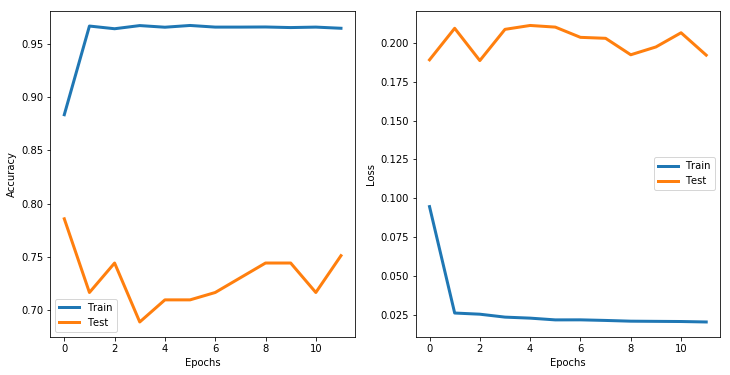

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(h1.history['acc'],label='Train',linewidth=3)
plt.plot(h1.history['val_acc'],label='Test',linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.subplot(1,2,2)
plt.plot(h1.history['loss'],label='Train',linewidth=3)
plt.plot(h1.history['val_loss'],label='Test',linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')